In [ ]:
from google.colab import files
uploaded = files.upload()

Saving INDIA_GDP.xlsx to INDIA_GDP.xlsx


In [ ]:


import numpy as np, pandas as pd
from numpy.linalg import inv
from pathlib import Path

FILE = "INDIA_GDP.xlsx"
SHEET = "Sheet1"
DATE_COL = "DATE"
VALUE_COL = "GDP"
IS_EXCEL = True
YOY_LAG = 4
N_ROWS = 10

rng = np.random.default_rng(12345)

def yoy_log_growth(series, lag=4):
    s = np.asarray(series, dtype=float)
    return np.log(s[lag:] / s[:-lag])

def build_ar2(y):
    y = np.asarray(y).reshape(-1)
    Y = y[2:]
    X = np.column_stack([np.ones(len(y)-2), y[1:-1], y[0:-2]])
    return Y, X

def ols(Y, X):
    XtX = X.T @ X
    XtX_inv = inv(XtX)
    beta_hat = XtX_inv @ (X.T @ Y)
    resid = Y - X @ beta_hat
    df = len(Y) - X.shape[1]
    sigma2_hat = float((resid.T @ resid) / df)
    return beta_hat, sigma2_hat

def gibbs_once(Y, X, n_iter=8000, burn=2000, thin=10, a0=2.0, b0_sig=2.0, v0=100.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(1)
    n, k = X.shape
    b0 = np.zeros(k)
    V0 = np.eye(k) * v0
    V0_inv = inv(V0)
    XtX = X.T @ X
    Xty = X.T @ Y
    beta = np.zeros(k); sigma2 = 1.0
    kept = (n_iter - burn + (thin - 1)) // thin
    B = np.zeros((kept, k)); S2 = np.zeros(kept); keep = 0
    for it in range(n_iter):
        Vn_inv = V0_inv + XtX
        Vn = inv(Vn_inv)
        bn = Vn @ (V0_inv @ b0 + Xty)
        beta = rng.multivariate_normal(bn, sigma2 * Vn)
        resid = Y - X @ beta
        an = a0 + n / 2.0
        beta_diff = beta - b0
        prior_quad = beta_diff @ (V0_inv @ beta_diff)
        bn_sig = b0_sig + 0.5 * (resid @ resid + prior_quad)
        U = rng.gamma(shape=an, scale=1.0 / bn_sig)
        sigma2 = 1.0 / U
        if it >= burn and ((it - burn) % thin == 0):
            B[keep] = beta
            S2[keep] = sigma2
            keep += 1
    return B, S2

if IS_EXCEL:
    df = pd.read_excel(FILE, sheet_name=SHEET)
else:
    df = pd.read_csv(FILE)

y_yoy = yoy_log_growth(df[VALUE_COL].dropna().values, lag=YOY_LAG)
Y, X = build_ar2(y_yoy)


beta_hat, sigma2_hat = ols(Y, X)


if Path("india_gdp_posterior_draws.csv").exists() and Path("india_gdp_sigma2_draws.csv").exists():
    draws = pd.read_csv("india_gdp_posterior_draws.csv")
    s2_draws = pd.read_csv("india_gdp_sigma2_draws.csv")["sigma2"].values
    if {"Intercept","lag1","lag2"}.issubset(draws.columns):
        B_draws = draws[["Intercept","lag1","lag2"]].values
    else:
        B_draws = draws.values
else:
    B_draws, s2_draws = gibbs_once(Y, X, rng=rng)

idx = rng.choice(len(B_draws), size=N_ROWS, replace=False)
B_sel = B_draws[idx]
S_sel = s2_draws[idx]

def make_table_frequentist():
    rows = []
    for i in range(N_ROWS):
        e = rng.normal(0.0, np.sqrt(sigma2_hat), size=4)
        rows.append({
            "No.": i+1,
            "beta0": round(beta_hat[0], 2),
            "beta1": round(beta_hat[1], 2),
            "beta2": round(beta_hat[2], 2),
            "sigma2": round(sigma2_hat, 2),
            "e1": round(e[0], 2), "e2": round(e[1], 2),
            "e3": round(e[2], 2), "e4": round(e[3], 2),
        })
    return pd.DataFrame(rows)

def make_table_bayesian():
    rows = []
    for i in range(N_ROWS):
        e = rng.normal(0.0, np.sqrt(S_sel[i]), size=4)
        rows.append({
            "No.": i+1,
            "beta0": round(B_sel[i,0], 2),
            "beta1": round(B_sel[i,1], 2),
            "beta2": round(B_sel[i,2], 2),
            "sigma2": round(S_sel[i], 2),
            "e1": round(e[0], 2), "e2": round(e[1], 2),
            "e3": round(e[2], 2), "e4": round(e[3], 2),
        })
    return pd.DataFrame(rows)

freq_table = make_table_frequentist()
bayes_table = make_table_bayesian()

freq_table, bayes_table


(   No.  beta0  beta1  beta2  sigma2    e1    e2    e3    e4
 0    1   0.06   0.83  -0.12     0.0  0.01  0.03  0.02 -0.02
 1    2   0.06   0.83  -0.12     0.0 -0.05 -0.09  0.00  0.06
 2    3   0.06   0.83  -0.12     0.0 -0.04  0.01 -0.01 -0.00
 3    4   0.06   0.83  -0.12     0.0  0.06  0.02  0.03 -0.03
 4    5   0.06   0.83  -0.12     0.0 -0.01 -0.03 -0.03  0.08
 5    6   0.06   0.83  -0.12     0.0  0.03  0.02 -0.01 -0.00
 6    7   0.06   0.83  -0.12     0.0 -0.01  0.01  0.03  0.04
 7    8   0.06   0.83  -0.12     0.0  0.08  0.04 -0.02  0.06
 8    9   0.06   0.83  -0.12     0.0 -0.00  0.06  0.04  0.04
 9   10   0.06   0.83  -0.12     0.0 -0.01 -0.10 -0.06  0.05,
    No.  beta0  beta1  beta2  sigma2    e1    e2    e3    e4
 0    1   0.21   1.00  -0.89    0.06 -0.31 -0.10 -0.00 -0.16
 1    2   0.05   1.09  -0.12    0.04  0.27  0.27  0.14 -0.21
 2    3   0.02   1.37  -0.36    0.07  0.07  0.02  0.04  0.26
 3    4  -0.04   0.14   1.16    0.07  0.35 -0.07 -0.09  0.29
 4    5   0.04   1.70  

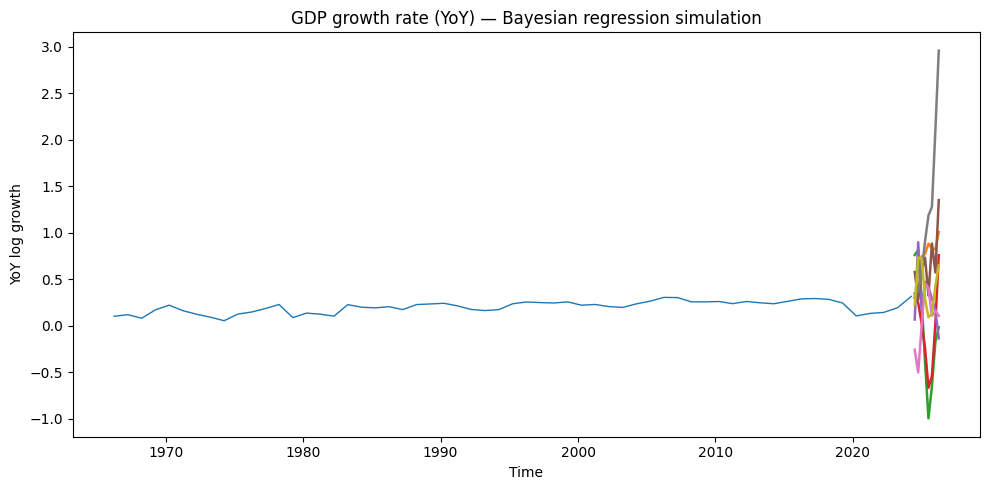

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pathlib import Path


FILE = "INDIA_GDP.xlsx"
SHEET = "Sheet1"
DATE_COL = "DATE"
VALUE_COL = "GDP"
YOY_LAG = 4
H = 8
N_PATHS = 8

rng = np.random.default_rng(2024)

def _require(cond, msg):
    if not cond:
        raise RuntimeError(msg)

def yoy_log_growth(series, lag=4):
    s = pd.to_numeric(pd.Series(series), errors="coerce").to_numpy()
    _require(np.isfinite(s).sum() > lag,
             f"Not enough numeric GDP observations after coercion. Need > {lag}.")
    return np.log(s[lag:] / s[:-lag])

def build_ar2(y):
    y = np.asarray(y, dtype=float).reshape(-1)
    _require(len(y) >= 3, "Need at least 3 observations after YoY to build AR(2).")
    return y[2:], np.column_stack([np.ones(len(y)-2), y[1:-1], y[0:-2]])

def gibbs_once(Y, X, n_iter=8000, burn=2000, thin=10, a0=2.0, b0_sig=2.0, v0=100.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(1)
    n, k = X.shape
    b0 = np.zeros(k); V0 = np.eye(k) * v0
    V0_inv = np.linalg.inv(V0)
    XtX = X.T @ X; Xty = X.T @ Y
    beta = np.zeros(k); sigma2 = 1.0
    kept = (n_iter - burn + (thin - 1)) // thin
    B = np.zeros((kept, k)); S2 = np.zeros(kept); keep = 0
    for it in range(n_iter):
        Vn_inv = V0_inv + XtX
        Vn = np.linalg.inv(Vn_inv)
        bn = Vn @ (V0_inv @ b0 + Xty)
        beta = rng.multivariate_normal(bn, sigma2 * Vn)
        resid = Y - X @ beta
        an = a0 + n / 2.0
        beta_diff = beta - b0
        prior_quad = beta_diff @ (V0_inv @ beta_diff)
        bn_sig = b0_sig + 0.5 * (resid @ resid + prior_quad)
        U = rng.gamma(shape=an, scale=1.0 / bn_sig)
        sigma2 = 1.0 / U
        if it >= burn and ((it - burn) % thin == 0):
            B[keep] = beta; S2[keep] = sigma2; keep += 1
    return B, S2


_is_excel = FILE.lower().endswith((".xlsx", ".xls"))
_require(Path(FILE).exists(),
         f"File '{FILE}' not found in the Colab working directory. "
         "Upload it again with `files.upload()` and check the exact name.")

df = pd.read_excel(FILE, sheet_name=SHEET) if _is_excel else pd.read_csv(FILE)
_require(DATE_COL in df.columns, f"DATE_COL '{DATE_COL}' not found. Columns: {list(df.columns)}")
_require(VALUE_COL in df.columns, f"VALUE_COL '{VALUE_COL}' not found. Columns: {list(df.columns)}")


date_raw = df[DATE_COL].astype(str).str.strip().replace({"": np.nan})
d = date_raw.dropna()

def _try_quarter_parse(s):
    s2 = (s.str.upper()
            .str.replace(r"\s+", "", regex=True)
            .str.replace("-", "", regex=False)
            .str.replace("_", "", regex=False))
    try:
        p = pd.PeriodIndex(s2, freq="Q")
        return p.to_timestamp(how="end"), "Q"
    except Exception:
        return None, None

dates, freq = _try_quarter_parse(d)
if dates is None:

    dates = pd.to_datetime(d, errors="coerce")
    freq = None


dates_full = pd.to_datetime(pd.Series(index=date_raw.index, dtype="datetime64[ns]"))
dates_full.loc[d.index] = pd.to_datetime(dates)


gdp = pd.to_numeric(df[VALUE_COL], errors="coerce")
mask = gdp.notna() & dates_full.notna()
gdp = gdp[mask].to_numpy()
dates = dates_full[mask]

_require(len(gdp) > YOY_LAG + 2,
         f"Too few valid rows after cleaning. Need at least {YOY_LAG+3} but have {len(gdp)}.")


y_yoy = yoy_log_growth(gdp, lag=YOY_LAG)
dates_yoy = dates.iloc[YOY_LAG:].to_numpy()
Y, X = build_ar2(y_yoy)
dates_hist = pd.to_datetime(dates_yoy[2:])

if Path("india_gdp_posterior_draws.csv").exists() and Path("india_gdp_sigma2_draws.csv").exists():
    draws = pd.read_csv("india_gdp_posterior_draws.csv")
    s2_draws = pd.read_csv("india_gdp_sigma2_draws.csv")["sigma2"].values
    if {"Intercept","lag1","lag2"}.issubset(draws.columns):
        B_draws = draws[["Intercept","lag1","lag2"]].values
    else:
        B_draws = draws.values
else:
    B_draws, s2_draws = gibbs_once(Y, X, rng=rng)

_require(len(B_draws) >= N_PATHS,
         f"Posterior draws ({len(B_draws)}) < N_PATHS ({N_PATHS}). Reduce N_PATHS or increase MCMC length.")

idx = rng.choice(len(B_draws), size=N_PATHS, replace=False)
B_sel = B_draws[idx]; S_sel = s2_draws[idx]


last_y1, last_y2 = float(Y[-1]), float(Y[-2])
paths = []
for i in range(N_PATHS):
    beta = B_sel[i]; s2 = S_sel[i]
    ypath = [last_y2, last_y1]
    for _ in range(H):
        x_next = np.array([1.0, ypath[-1], ypath[-2]])
        y_next = x_next @ beta + rng.normal(0.0, np.sqrt(s2))
        ypath.append(y_next)
    paths.append(ypath[2:])
paths = np.array(paths)


last_date = pd.to_datetime(dates_hist[-1])
try:
    inferred = pd.infer_freq(pd.to_datetime(dates_hist))
except Exception:
    inferred = None

if freq == "Q" or (inferred and inferred.startswith("Q")):
    future_dates = pd.period_range(last_date, periods=H+1, freq="Q").to_timestamp(how="end")[1:]
elif inferred and "M" in inferred:
    future_dates = pd.date_range(last_date, periods=H+1, freq="M")[1:]
else:

    future_dates = np.arange(len(dates_hist), len(dates_hist) + H)

plt.figure(figsize=(10,5))
plt.plot(dates_hist, Y, linewidth=1.0)
for i in range(N_PATHS):
    plt.plot(future_dates, paths[i], linewidth=1.8)
plt.title("GDP growth rate (YoY) — Bayesian regression simulation")
plt.xlabel("Time"); plt.ylabel("YoY log growth")
plt.tight_layout()
plt.show()
